<a href="https://colab.research.google.com/github/mairakhan5/mairakhan5/blob/main/Lecture_2_Follow_along.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import matplotlib.pyplot as plt


def generate_linear_data(a=1.8, b=32., sigma=2.5, n=100, seed=42):
  """Generates some random data with linear shape."""
  np.random.seed(seed)
  x = np.random.rand(n) * 20.
  err = np.random.normal(loc=0., scale=sigma, size=n)
  y = a * x + b + err
  return x, y

def generate_cosine_data(a=1.1, b=1.23, sigma=.4, n=25, seed=42):
  """Generates some random data with cosine shape."""
  np.random.seed(seed)
  x = np.random.rand(n) * 10.
  err = np.random.normal(loc=0., scale=sigma, size=n)
  y = np.cos(a * x) + b + err
  return x, y

def generate_classification_data(a=1.0, b=3.0, sigma=.8, n=30, seed=42):
  np.random.seed(seed)
  positive = np.random.randint(n/3, 2*n/3)
  negative = n - positive
  x_pos = np.random.normal(loc=a, scale=sigma, size=positive)
  x_neg = np.random.normal(loc=b, scale=sigma, size=negative)
  x = np.concatenate([x_pos, x_neg])
  y = np.concatenate([np.ones(positive), np.zeros(negative)])
  return x, y

# Lecture 2
# Linear models in machine learning

In the previous lecture, we learned how to manipulate datasets using the Pandas library. This tool can be incredibly useful to solve many data science problems, but it falls short at one crucial task: building predictive models of our data. In this lecture, we will be covering this missing link.

Broadly speaking, there are two main types of predictive tasks in machine learning: classification and regression.

- Classification is a predictive task in which the goal is to predict a discrete class label for a given input. Some common examples of classification tasks include spam detection, image classification, and natural language processing.

- Regression is a predictive task in which the goal is to predict a continuous value for a given input. Like classification, this involves learning a model from labeled training data and using the trained model to make predictions on new, unseen examples. Some common examples of regression tasks include predicting housing prices, stock prices, and sales data.

Both processes can be thought of as a two-step process, where the first step is to learn a model from labeled training data, and the second step is to use the trained model to predict some numerical value on a different amount of data.

## What is learning, really?

Before discussing *how* to make a computer code "learn", we should first discuss a related question: *how do we know if the computer code has learned*. To do this, we will be turning on the abstraction for a little bit. We will consider a toy problem: how to determine, from a set of measurements, the rule for converting between Celsius and Fahrenheit degrees. The same principles that govern this simple problem can then be extended to all sort of questions, from interpreting text, classifying pictures or predicting the movements of financial markets.

Let us start by generating some "training data", which corresponds to two cheap thermometers (i.e. their measurements carry an error of about 2-3 degrees either side), one in Celsius and one in Fahrenheit.

Text(0, 0.5, 'Fahrenheit')

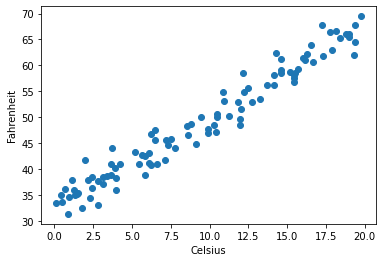

In [ ]:
x, y = generate_linear_data()
plt.scatter(x, y)
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')

There are different models that we may want to consider, for example:

- Take the temperature in Celsius, multiply it by 2 and add 30 ($ y = 2x + 30 $)
- Take the temperature in Celsius, multiply it by 2.5 and add 28 ($ y = 2x + 28 $)
- Take the temperature in Celisus, square it, divide by 10 and add 30 ($ y = 0.1x^2 + 30 $)

Text(0, 0.5, 'Fahrenheit')

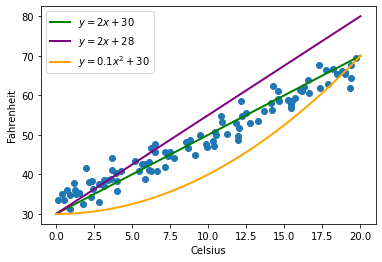

In [ ]:
def plot_model(model, color, label):
  x_ = np.linspace(0., 20., 100)
  plt.plot(x_, model(x_), color=color, label=label, linewidth=2)

model_1 = lambda x: 2 * x + 30
model_2 = lambda x: 2.5 * x + 30
model_3 = lambda x: 0.1 * x*x + 30

plt.scatter(x, y)
plot_model(model_1, 'green', '$y=2x+30$')
plot_model(model_2, 'purple', '$y=2x+28$')
plot_model(model_3, 'orange', '$y=0.1x^2+30$')
plt.legend()
plt.xlabel('Celsius')
plt.ylabel('Fahrenheit')

Visually, it looks like the first model is much better than the other two, but of course we want a mathematical definition that is not biased by our interpretation (is it better to multiply by 2, or by 2.1? Could we see the difference?) and that can be applied to potentially many models without human intervention. We normally do this by defining a *loss function*. In a regression problem, such as this, it is common to use the *mean squared error*:

$$ \mathcal{L} = \frac{1}{N}\sum_{i=1}^N \left[y_i - \hat{f}(x_i)\right]^2 $$

In [ ]:
def loss_function(predicted_data, true_data):
  """Quantifies the goodness of a model by comparing
  the predicted data with the true data, using the
  mean absolute error."""
  return np.square(true_data - predicted_data).mean()

loss_1 = loss_function(y, model_1(x))
loss_2 = loss_function(y, model_2(x))
loss_3 = loss_function(y, model_3(x))

print('Loss for model 1 =', loss_1)
print('Loss for model 2 =', loss_2)
print('Loss for model 3 =', loss_3)

Loss for model 1 = 7.3779994431178295
Loss for model 2 = 46.17359704489186
Loss for model 3 = 55.92903447699303


## How do we find the best parameters for our model?

If we know a way to quantify how well or how badly a model is doing, we can then tinker with our model to make this loss function as small as possible.

**General recipe for machine learning.** Come up for a model, define a loss function, then adjust the parameters of the model to make the loss function as small as possible.

In [ ]:
def compute_loss(a, b):
  y_pred = a * x + b
  return loss_function(y_pred, y)

In [ ]:
compute_loss(2., 30)

7.3779994431178295

In [ ]:
compute_loss(1.9, 30)

7.027317081481383

Okay, lowering the slope from 2. to 1.9 improved the loss. Let's see what happens if we change the intercept as well:

In [ ]:
compute_loss(1.9, 32)

6.799566630180623

**Exercise 1.** Manually tune the parameters *a* and *b* to minimise the value of the loss.

## There must be a better way, surely

There is only so far that you can go by doing.

In [ ]:
import torch


def model(x, a, b):
  x_ = torch.tensor(x)
  return a * x_ + b

def loss_fn(a, b, x, y):
  pred_ = model(x, a, b)
  y_ = torch.tensor(y)
  return torch.mean((pred_ - y_).square())

def calc_grad(a, b, x, y):
  a = torch.tensor(a, requires_grad=True)
  b = torch.tensor(b, requires_grad=True)
  loss = loss_fn(a, b, x, y)
  loss.backward()
  return a.grad.clone(), b.grad.clone()

nabla_a, nabla_b = calc_grad(2.0, 30.0, x, y)
print('Gradient with respect to a =', nabla_a.item())
print('Gradient with respect to b =', nabla_b.item())

Gradient with respect to a = 15.854218482971191
Gradient with respect to b = -0.23315225541591644


We can use the gradients to orient our choice of parameter changes:

In [ ]:
a = 2.0
b = 30.0

print('Original loss =', loss_fn(a, b, x, y))

nabla_a, nabla_b = calc_grad(a, b, x, y)
a = a - 10E-5 * nabla_a
b = b - 10E-5 * nabla_b

print('New loss =', loss_fn(a, b, x, y))

Original loss = tensor(7.3780, dtype=torch.float64)
New loss = tensor(7.3532, dtype=torch.float64)


**Exercise 2.** The algorithm we have described (which is known as *gradient descent*) is a general process to train a machine learning model. The process is normally described as follows:

```
Initialise parameters a and b
For a set number of iterations..
    Calculate loss function
    Calculate gradient with respect to a and b
    Update the values of a and b accordingly, as:
        a = a - alpha * a
        b = b - alpha * b
    where alpha is a small parameter (e.g. 10e-5)
```

Implement a code block to enact this algorithm for the linear regression problem defined above, and determine the optimal parameters $a$ and $b$.

In [ ]:
a = 2.0
b = 30.0

n_iterations = 10000
for k in range(n_iterations):
  grad_a, grad_b = calc_grad(x, y, a, b)
  a = a - 1. * grad_a
  b = b - 1. * grad_b

  if k % 100 == 0:
    print(loss_fn(a, b, x, y))

tensor(731.3477, dtype=torch.float64)
tensor(26417.1819, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)


<ipython-input-30-bed9c56a0968>:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_ = torch.tensor(x)
<ipython-input-30-bed9c56a0968>:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_ = torch.tensor(y)


tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan, dtype=torch.float64)
tensor(nan

## How can we be sure that this works?



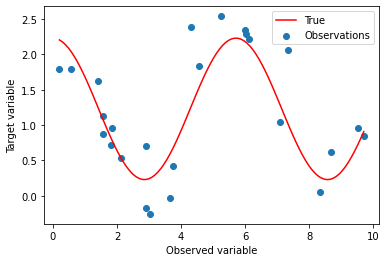

In [ ]:
x, y = generate_cosine_data()
x_ = np.linspace(x.min(), x.max(), 100)
y_ = np.cos(1.1 * x_) + 1.23
plt.scatter(x, y, label='Observations')
plt.plot(x_, y_, color='red', label='True')
plt.xlabel('Observed variable')
plt.ylabel('Target variable')
plt.legend()

Fitting a cubic model is not much different than fitting a linear one:

$$ \hat{f}(x) = \sum_{i=1}^N a_k x^k\ + b $$
$$ \mathcal{L}(x, y) = \sum_{i=1}^N\left[ \hat{f}(x_i) - y_i \right]^2 $$

In [ ]:
import numpy as np

def model(x, params):
  return np.polyval(params, x)

def loss_fn(params, x, y):
  preds = model(x, params)
  return np.square(preds - y).mean()

params = np.polyfit(x, y, 3)
params

array([-0.02572863,  0.36668118, -1.34622122,  2.19909253])

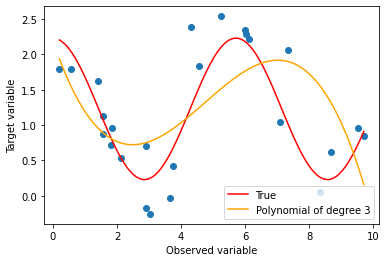

In [ ]:
y_pred = model(x_, params)
plt.plot(x_, y_, color='red', label='True')
plt.plot(x_, y_pred, color='orange', label='Polynomial of degree 3')
plt.scatter(x, y,)
plt.xlabel('Observed variable')
plt.ylabel('Target variable')
plt.legend()

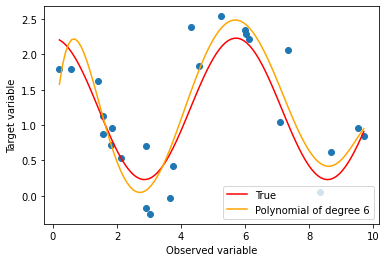

In [ ]:
params = np.polyfit(x, y, 6)

y_pred = model(x_, params)
plt.plot(x_, y_, color='red', label='True')
plt.plot(x_, y_pred, color='orange', label='Polynomial of degree 6')
plt.scatter(x, y,)
plt.xlabel('Observed variable')
plt.ylabel('Target variable')
plt.legend()

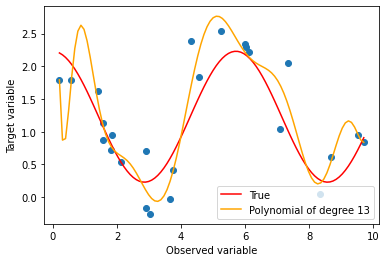

In [ ]:
params = np.polyfit(x, y, 13)

y_pred = model(x_, params)
plt.plot(x_, y_, color='red', label='True')
plt.plot(x_, y_pred, color='orange', label='Polynomial of degree 13')
plt.scatter(x, y,)
plt.xlabel('Observed variable')
plt.ylabel('Target variable')
plt.legend()

**Overfitting** is a phenomenon that occurs when a model is too complex and is able to fit the noise in the data, rather than the underlying pattern. This can lead to poor generalization performance, as the model will not be able to make accurate predictions on new, unseen data.

There are several techniques to detect overfitting and ensure that the training models can generalize to new, unseen data. The most common techniques are *train/test splits* and *cross-validation*. The basic idea behind both of these techniques is to divide the data into a training set, which is used to train the model, and a test set, which is used to evaluate the model's performance. By training the model on the training set and evaluating it on the test set, we can estimate how well the model will perform on new, unseen data. If the model performs well on the test set, it is likely to generalize well to new, unseen data. However, if the model performs poorly on the test set, it is likely to be overfitting the training data. Intuitively, you may think that the error on the test set determines if the model has learned the noise on the data, or the underlying pattern.

The most common approach is to divide the total data into two independent sub-datasets, which are called the *training* and *test* splits (typically ~70-80% of the data is used for training, and 20-30% for testing). The training set is used to find hte optimal parameters (i.e. *train*) the model. and the test set is used to evaluate the final performance. This approach provides an unbiased estimate of the model's performance on unseen data.

In most practical cases data is scarce, so a useful alternative $k$-fold cross-validation. In this method, the data is divided into $k$ independent sub-datasets, or "folds". The model is trained on $k-1$ of the folds and tested on the remaining fold. This process is repeated $k$ times, each time with a different fold as the test set. By averaging the performance across all $k$ iterations, we can get a more robust estimate of the model's performance and detect overfitting.




In [ ]:
from sklearn.model_selection import train_test_split

train_x, test_x, train_y, test_y = train_test_split(
    x, y, test_size=0.20
)

cubic_fit = np.polyfit(train_x, train_y, deg=3)
massive_fit = np.polyfit(train_x, train_y, deg=10)

print('Training loss for the cubic model =',
  loss_fn(cubic_fit, train_x, train_y))
print('Test loss for the cubic model =',
  loss_fn(cubic_fit, test_x, test_y))
print('Training loss for the 10th degree model =',
  loss_fn(massive_fit, train_x, train_y))
print('Test loss for the 10th degree model =',
  loss_fn(massive_fit, test_x, test_y))

Training loss for the cubic model = 0.458455325142664
Test loss for the cubic model = 0.6314579982751134
Training loss for the 10th degree model = 0.09195234457516718
Test loss for the 10th degree model = 0.7491708854161494


It is also quite common to divide the training set further into a *de facto* training set, and a validation set which we use to determine optimal choices for the model, like the degree of the polynomial we fit, or the learning rate in gradient descent (we call these choices *hyperparameters*, and they will play a very important role in next class).

**Exercise 3.** Divide the training set (`train_x` and `train_y`) into a *de facto* training set and a validation set. Then, use the same strategy as in the previous set to find the optimal degree $k$ to train.
*Hint:* calculate the difference between the training and validation losses for different values of $k$. After you are done, check on the test set (`test_x` and `test_y`).

In [ ]:
train_x, test_x, train_y, test_y = train_test_split(
    x, y, test_size=0.1
)
dftrain_x, valid_x, dftrain_y, valid_y = train_test_split(
    train_x, train_y, test_size=0.2
)

In [ ]:
def train_model(k):
  params = np.polyfit(dftrain_x, dftrain_y, deg=k)
  return loss_fn(params, valid_x, valid_y)

for k in range(3, 15):
  print('For degree', k, 'loss_fn =', train_model(k))

For degree 3 loss_fn = 0.79787358991635
For degree 4 loss_fn = 0.44810332623925725
For degree 5 loss_fn = 0.5644816828326881
For degree 6 loss_fn = 0.38228589078387853
For degree 7 loss_fn = 0.38720716600417854
For degree 8 loss_fn = 0.374771982070941
For degree 9 loss_fn = 0.3578315714134209
For degree 10 loss_fn = 0.4383743135234794
For degree 11 loss_fn = 3.5132808143967202
For degree 12 loss_fn = 4.684049842074765
For degree 13 loss_fn = 52.69152955001833
For degree 14 loss_fn = 43.74968585384783


In [ ]:
params = np.polyfit(train_x, train_y, deg=k)
loss_fn(params, test_x, test_y)

0.16252308628309522

## How can we do this for classification?

The models we have discussed so far have dealt with the problem of *regression*, but a good number of problems in data science deal with *classification*. Fortunately, there is a simple way in which we can extend these models to classification. In this introductory class, we will be discussing logistic regression on a toy classification dataset.

Text(0, 0.5, 'Measured variable')

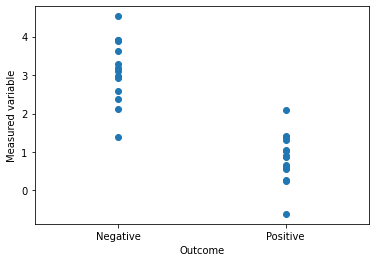

In [ ]:
x, y = generate_classification_data()

fig, ax = plt.subplots()
ax.scatter(y, x)
ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0., 1.])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_xlabel('Outcome')
ax.set_ylabel('Measured variable')

Logistic regression can be understood as an extension of linear regression that is applied to the *log-odds* (which we also know as "logits") of a binary outcome. Whereas in linear regression the goal is to model the relationship between a set of independent variables and a continuous dependent variable, in logistic regression the goal is to model the relationship between a set of independent variables and a binary dependent variable.

$$ \text{Odds} = \frac{P}{1 - P} $$
$$ \log \text{Odds} = \log\left[\frac{P}{1 - P}\right] $$

In logistic regression, the log-odds of the binary outcome, is modeled as a linear combination of the features. The equation for logistic regression is given by:

$$ \log\left[\frac{P}{1 - P}\right] = a + bx $$

This equation can be transformed back to the probability of the positive outcome by:

$$ P = \frac{e^{a+bx}}{1 + e^{a+bx}} $$

In [ ]:
bfrom tqdm.notebook import trange

def sigmoid(x):
  return 1 / (1 + torch.exp(-x))

def model(x, a, b):
  return sigmoid(a + b * x)

def loss_fn(a, b, x, y):
  preds = model(x, a, b)
  return torch.square(preds - y).mean()

def calc_grad(a, b, x, y):
  a = torch.tensor(a, requires_grad=True)
  b = torch.tensor(b, requires_grad=True)
  x = torch.tensor(x)
  y = torch.tensor(y)
  loss = loss_fn(a, b, x, y)
  loss.backward()
  return a.grad.clone(), b.grad.clone()

a = 1.; b = 3.
for k in trange(5000):
  nabla_a, nabla_b = calc_grad(a, b, x, y)
  a = a - 1e0 * nabla_a
  b = b - 1e0 * nabla_b

  0%|          | 0/5000 [00:00<?, ?it/s]

<ipython-input-109-71d9b1edb6eb>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  a = torch.tensor(a, requires_grad=True)
<ipython-input-109-71d9b1edb6eb>:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  b = torch.tensor(b, requires_grad=True)


After we have trained the logistic regression, we can use the model to predict the probability that a sample will be positive or negative:

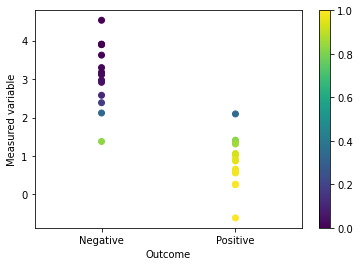

In [ ]:
import matplotlib.cm as cm


preds = model(x, a, b).numpy()

fig, ax = plt.subplots()
s = ax.scatter(y, x, color=cm.viridis(preds))
ax.set_xlim(-0.5, 1.5)
ax.set_xticks([0., 1.])
ax.set_xticklabels(['Negative', 'Positive'])
ax.set_xlabel('Outcome')
ax.set_ylabel('Measured variable')
plt.colorbar(s)

These probabilities can be very convenient when making decisions based on the predictions. This is because it allows us to set a threshold for the decision, and any prediction above the threshold is considered a positive outcome while any prediction below the threshold is considered a negative outcome.

For example, in a medical setting, when a patient takes a test and the results are processed by logistic regression, the model will output the probability of the patient having a certain condition. If the threshold is set at 0.5, any probability greater than 0.5 will be considered as positive, which means the patient has the condition, and requires treatment. However, if the threshold is set at 0.7, only the patient with a probability greater than 0.7 will be considered as positive and require treatment. This threshold can be adjusted based on the severity of the condition, the risk of misdiagnosis and the cost of treatment.

## How do we do this in the real world?

In practical data science applications, we rarely need to implement explicit models. There are very many libraries that we can use to train these models with a few lines of code. One of the most popular libraries is *sci-kit learn*, which we will be using throughout this course.

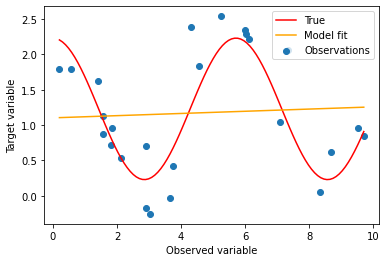

In [ ]:
from sklearn.linear_model import LinearRegression

x, y = generate_cosine_data()
model = LinearRegression()
model.fit(x.reshape(-1, 1), y.reshape(-1, 1))
x_ = np.linspace(x.min(), x.max(), 100)
preds = model.predict(x_.reshape(-1, 1))

y_ = np.cos(1.1 * x_) + 1.23
plt.scatter(x, y, label='Observations')
plt.plot(x_, y_, color='red', label='True')
plt.plot(x_, preds, color='orange', label='Model fit')
plt.xlabel('Observed variable')
plt.ylabel('Target variable')
plt.legend()

**Exercise 4.** Use sci-kit learn to perform a linear regression on the synthetic data we used at the beginning of the lesson. You can import a linear regression model using the ``from sklearn.linear_model import LinearRegression``.

**Exercise 5.** Use sci-kit learn to perform a logistic regression on the Titanic data we used in the previous lesson to predict the probability that a person will survive based on their age. You can import a logistic regression using the ``from sklearn.linear_model import LogisticRegression``.